In [1]:
!which python

/home/prat/.pyEnvs/tutorial-mlops/bin/python


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Load the CSV data

In [3]:
data = pd.read_csv('data/dataset_train_test.csv', sep=';', decimal=',')

In [4]:
data.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,NaN,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,NaN,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


## Check datatypes

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9562 entries, 0 to 9561
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Entreprise    7636 non-null   object 
 1   Metier        9562 non-null   object 
 2   Technologies  9562 non-null   object 
 3   Diplome       9562 non-null   object 
 4   Experience    8531 non-null   float64
 5   Ville         9562 non-null   object 
dtypes: float64(1), object(5)
memory usage: 448.3+ KB


## Check for the presence of NAN

In [6]:
data.isna().sum()

Entreprise      1926
Metier             0
Technologies       0
Diplome            0
Experience      1031
Ville              0
dtype: int64

<div class="alert alert-block alert-info">
    <b>Lets know more about the features before deciding what to do with the NANs..</b>
</div>

## Check Unique Values

In [7]:
data.Metier.unique()

array(['Data scientist', 'Data architecte', 'Lead data scientist',
       'Data engineer'], dtype=object)

In [8]:
data.Diplome.unique()

array(['Master', 'Phd', 'Bachelor', 'BSc', 'MSc', 'No diploma', 'PhD',
       'MASTER', 'master', 'bachelor', 'NO', 'msc', 'Mastere'],
      dtype=object)

<div class="alert alert-block alert-info">
    <b>Lets fix the duplicate values in `Diplome`..</b>
</div>

In [9]:
data.loc[data.Diplome == 'PhD', 'Diplome'] = 'Phd'
data.loc[data.Diplome == 'NO', 'Diplome'] = 'No diploma'
data.loc[data.Diplome.isin(['MASTER', 'MSc', 'Mastere', 'msc', 'master']), 'Diplome'] = 'Master'
data.loc[data.Diplome.isin(['bachelor', 'BSc']), 'Diplome'] = 'Bachelor'

In [10]:
data.Diplome.unique()

array(['Master', 'Phd', 'Bachelor', 'No diploma'], dtype=object)

In [11]:
data.Ville.unique()

array(['Paris', 'Marseille', 'Nantes', 'Bordeaux', 'Lille', 'Toulouse',
       'Rouen', 'Lyon', 'Strasbourg', 'Grenoble', 'Nice', 'Toulon',
       'Montpellier', 'Rennes'], dtype=object)

In [12]:
data.Entreprise.unique()

array(['Sanofi', 'Massachusetts General Hospital(MGH)', nan, ...,
       'Galvanize', 'Marsh', 'Ra Pharmaceutical'], dtype=object)

In [13]:
data.Entreprise.nunique()

1320

## Fixing the NANs

In [14]:
# number of records where both `Entreprise` and `Experience` are NAN
data[(data.Entreprise.isna()) & (data.Experience.isna())].shape[0]

197

In [15]:
# number of records where `Experience` is NAN and `Entreprise` is not
# which implies they must have experience..
data[(~data.Entreprise.isna()) & (data.Experience.isna())].shape[0]

834

In [16]:
# total NAN in Experience is equal to the sum of the above two?
data[(~data.Entreprise.isna()) & (data.Experience.isna())].shape[0] + data[(data.Entreprise.isna()) & (data.Experience.isna())].shape[0], \
data.Experience.isna().sum()

(1031, 1031)

<div class="alert alert-block alert-info">
    <b>We can use the `Metier` to fill the NAN in experience where we know the profile if of a person currently working</b>
</div>

In [17]:
mean_exp = data.groupby('Metier')['Experience'].mean().to_dict()
mean_exp

{'Data architecte': 2.9949387320191794,
 'Data engineer': 2.963747645951036,
 'Data scientist': 2.255155387743247,
 'Lead data scientist': 3.96688132474701}

In [18]:
for k, v in mean_exp.items():
    mean_exp[k] = round(v * 2) / 2
mean_exp

{'Data architecte': 3.0,
 'Data engineer': 3.0,
 'Data scientist': 2.5,
 'Lead data scientist': 4.0}

In [19]:
for k, v in mean_exp.items():
    data.loc[(~data.Entreprise.isna()) & (data.Experience.isna()) & (data.Metier == k), 'Experience'] = v

<div class="alert alert-block alert-info">
    <b>Lets set the experience to Zero for those that not currently working..</b>
</div>

In [20]:
data.loc[(data.Entreprise.isna()) & (data.Experience.isna()), 'Experience'] = 0

In [21]:
# confirm all Experience are valid now
data.isna().sum()

Entreprise      1926
Metier             0
Technologies       0
Diplome            0
Experience         0
Ville              0
dtype: int64

In [22]:
# set the NAN in `Entreprise` to UNKNOWN
data.loc[data.Entreprise.isna(), 'Entreprise'] = 'UNKNOWN'

In [23]:
data.isna().sum()

Entreprise      0
Metier          0
Technologies    0
Diplome         0
Experience      0
Ville           0
dtype: int64

## Distribution of Experience

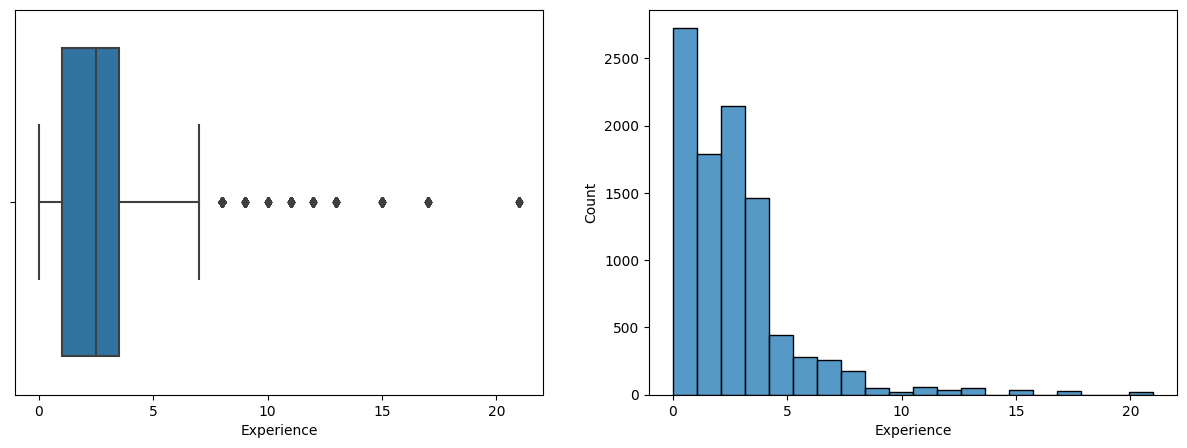

In [24]:
fig = plt.gcf()
fig.set_size_inches(15, 5)
ax = fig.add_subplot(121)
_ = sns.boxplot(data, x='Experience', ax=ax)
ax = fig.add_subplot(122)
_ = sns.histplot(data.Experience, bins=20, ax=ax)

## Preparing the `Technologies` feature for sklearn DictVectorizer

In [25]:
# lets check the unique Technologies
all_tech = '/'.join(data.Technologies)

# using the python `set` to remove duplicates
all_tech = set(map(lambda x: x.lower(), all_tech.split('/')))
len(all_tech), all_tech

(57,
 {'',
  'ai',
  'anglais',
  'aws',
  'big data',
  'c',
  'c++',
  'cassandra',
  'deep learning',
  'docker',
  'elasticsearch',
  'excel',
  'gnu',
  'hadoop',
  'hadoop(hdfs)',
  'hbase',
  'hdfs',
  'hive',
  'java',
  'kafka',
  'kibana',
  'linux',
  'machine learning',
  'map-reduce',
  'mariadb',
  'matlab',
  'matplotlib',
  'microsoft azure',
  'mongodb',
  'mysql',
  'nosq',
  'nosql',
  'numpy',
  'oracle',
  'perl',
  'pig',
  'postgresql',
  'pycharm',
  'pyspark',
  'python',
  'r',
  'redshift',
  'ruby',
  'sas',
  'scala',
  'scikit-learn',
  'scoring',
  'spark',
  'spss',
  'sql',
  'tableau',
  'tensorflow',
  'teradata',
  'vba',
  'vertica',
  'windows',
  'yarn'})

<div class="alert alert-block alert-info">
    <b>We can see issues like `nosq` and `nosql`, `''`, `hadoop`, `hadoop(hdfs)`, `hdfs`</b>
</div>

In [26]:
data['Technologies'] = data['Technologies'].str.lower()

# fixing `''`
data.loc[data['Technologies'].str.contains('//'), 'Technologies'] = data['Technologies'].str.replace('//', '/', regex=False)

# fixing `nosq`
data.loc[data['Technologies'].str.contains('/nosq/'), 'Technologies'] = data['Technologies'].str.replace('/nosq/', '/nosql/', regex=False)

In [27]:
# creating synonyms to replace

synonyms = {'hadoop(hdfs)': 'hadoop', 
            'hdfs': 'hadoop'} 

for syn, parent in synonyms.items():
    data.loc[data['Technologies'].str.contains(syn, regex=False), 'Technologies'] = data['Technologies'].str.replace(syn, parent, regex=False)

In [28]:
data['Techlist'] = data.Technologies.apply(lambda x: x.split('/'))
data.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Techlist
0,Sanofi,Data scientist,matlab/python/pyspark/scikit-learn/tensorflow,Master,1.0,Paris,"[matlab, python, pyspark, scikit-learn, tensor..."
1,Massachusetts General Hospital(MGH),Data architecte,python/java/scala/mongodb,Master,3.0,Marseille,"[python, java, scala, mongodb]"
2,UNKNOWN,Lead data scientist,spss/sql/teradata/r/python/tensorflow/scikit-l...,Master,3.0,Nantes,"[spss, sql, teradata, r, python, tensorflow, s..."
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,c/c++/java/python,Master,1.5,Marseille,"[c, c++, java, python]"
4,UNKNOWN,Data scientist,matlab/python/c++/numpy/tensorflow/scikit-learn,Phd,0.0,Bordeaux,"[matlab, python, c++, numpy, tensorflow, sciki..."


In [29]:
data.to_csv('data/data_clean.csv')

## Train Pipeline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import mlflow

In [14]:
def read_data(p = 'data/data_clean.csv'):
    """
    Read the cleaned data from feature engineering step for training.
    """
    
    data = pd.read_csv(p)
    data['Techlist'] = data.Technologies.apply(lambda x: x.split('/'))
    return data

In [15]:
def get_features(data, features, target):
    """
    Return X and y vectors from dataset.
    """
    X, y = data[features].copy(), data[target].copy()
    
    return X, y

In [35]:
def get_pipeline(model, params=None):
    """
    Given a classifier and params, return a pipeline object.
    """
    params = {} if params is None else params
    
    return Pipeline([('vectorize', DictVectorizer()),
                     ('model', model(**params))])

In [41]:
def get_confusion_matrix(pred_train, y_train, pred_test, y_test):
    from sklearn.metrics import ConfusionMatrixDisplay

    fig = plt.figure()
    fig.set_size_inches(18, 5)

    # Train 
    ax = fig.add_subplot(121)

    ConfusionMatrixDisplay.from_predictions(y_train, pred_train, ax=ax)
    ax.xaxis.set_ticklabels(data.Metier.unique(), rotation=45)
    ax.yaxis.set_ticklabels(data.Metier.unique())
    _ = ax.set_title(
        f"TrainSet Confusion Matrix"
    )

    # Test
    ax = fig.add_subplot(122)

    ConfusionMatrixDisplay.from_predictions(y_test, pred_test, ax=ax)
    ax.xaxis.set_ticklabels(data.Metier.unique(), rotation=45)
    ax.yaxis.set_ticklabels(data.Metier.unique())
    _ = ax.set_title(
        f"TestSet Confusion Matrix"
    )

    return fig

2023/03/26 14:21:24 INFO mlflow.tracking.fluent: Experiment with name 'baseline_newer' does not exist. Creating a new experiment.


Train score: 0.9657471564910446
Test score: 0.8797699947726084


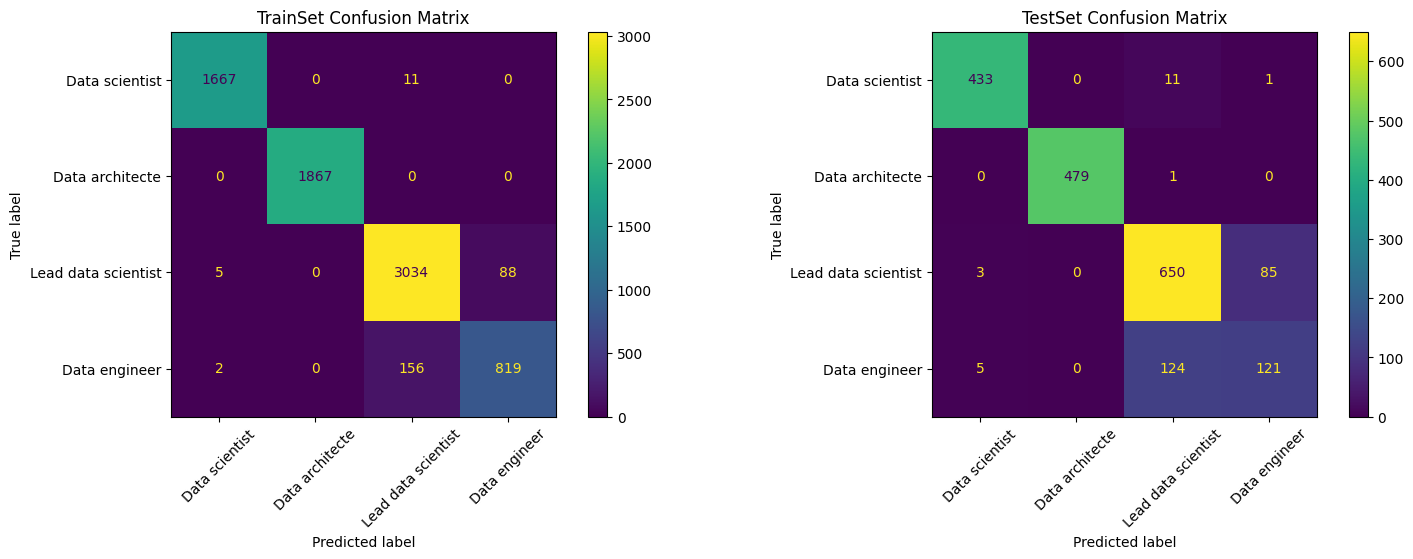

In [102]:
data = read_data()
X, y = get_features(data, 
                    features=['Diplome', 'Ville', 'Techlist', 'Experience'], 
                    target='Metier')

mlflow.set_tracking_uri('http://18.157.175.19:5000/')
mlflow.set_experiment('baseline_newer')

with mlflow.start_run():
    
    mlflow.log_param('test_size', 0.2)
    mlflow.log_param('data_split_r_state', "121")
    mlflow.log_param('features', ['Diplome', 'Ville', 'Techlist', 'Experience'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121, shuffle=True)

    X_train = X_train.to_dict(orient='records')
    X_test = X_test.to_dict(orient='records')

    train_pipeline = get_pipeline(RandomForestClassifier)
    train_pipeline.fit(X_train, y_train)
    trn_preds = train_pipeline.predict(X_train)
    tst_preds = train_pipeline.predict(X_test)
    
    trn_score = train_pipeline.score(X_train, y_train)
    tst_score = train_pipeline.score(X_test, y_test)
    
    mlflow.sklearn.log_model(train_pipeline, artifact_path='models')
    mlflow.log_metric("train_score", trn_score)
    mlflow.log_metric("test_score", tst_score)

    print(f"Train score: {trn_score}")
    print(f"Test score: {tst_score}")

    fig = get_confusion_matrix(trn_preds, y_train, tst_preds, y_test)
    mlflow.log_figure(fig, artifact_file='confusion_matrix.png')

## Model Registry

In [3]:
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType


MLFLOW_TRACKING_URI = "http://18.157.175.19:5000/"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)


runs = client.search_runs(
    experiment_ids=3,
    filter_string="metrics.test_score > 0.85",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.test DESC"]
)

for run in runs:
    print(f"run id: {run.info.run_id}, test score: {run.data.metrics['test_score']:.4f}")

run id: 367ab3acaf054e98a2cfa5c051a26b40, test score: 0.8798


In [104]:
run_id = "367ab3acaf054e98a2cfa5c051a26b40"
model_uri = f"runs:/{run_id}/models"
mlflow.register_model(model_uri=model_uri, name="baseline_rf")

Registered model 'baseline_rf' already exists. Creating a new version of this model...
2023/03/26 14:21:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: baseline_rf, version 2
Created version '2' of model 'baseline_rf'.


<ModelVersion: creation_timestamp=1679833313762, current_stage='None', description='', last_updated_timestamp=1679833313762, name='baseline_rf', run_id='367ab3acaf054e98a2cfa5c051a26b40', run_link='', source='s3://prat-mlops-artifacts/3/367ab3acaf054e98a2cfa5c051a26b40/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='2'>

### Checking models currently in the registry

In [105]:
model_name = "baseline_rf"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Staging
version: 2, stage: None


In [108]:
# push the model to staging

model_version = 2
new_stage = "Staging"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=True
)

<ModelVersion: creation_timestamp=1679833313762, current_stage='Staging', description='', last_updated_timestamp=1679833342298, name='baseline_rf', run_id='367ab3acaf054e98a2cfa5c051a26b40', run_link='', source='s3://prat-mlops-artifacts/3/367ab3acaf054e98a2cfa5c051a26b40/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='2'>

In [5]:
model_name = "baseline_rf"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Archived
version: 2, stage: Staging


In [7]:
mlflow.set_tracking_uri('http://18.157.175.19:5000/')
mlflow.set_experiment('baseline_newer')

stage_model = mlflow.sklearn.load_model(f"models:/{model_name}/Staging")

In [ ]:
# model_uri = f"models:/{model_name}/Staging"
# mlflow models serve -m "models:/sk-learn-random-forest-reg-model/Production"

In [25]:
data = read_data()

In [43]:
data.Techlist[0].replace("'", '"')

'["matlab", "python", "pyspark", "scikit-learn", "tensorflow"]'

In [33]:
import ast
ast.literal_eval("['matlab', 'python', 'pyspark', 'scikit-learn', 'tensorflow']")

['matlab', 'python', 'pyspark', 'scikit-learn', 'tensorflow']

In [41]:
import json
json.loads('["matlab", "python", "pyspark", "scikit-learn", "tensorflow"]')

['matlab', 'python', 'pyspark', 'scikit-learn', 'tensorflow']

In [45]:
json.loads(data.Techlist[0].replace("'", '"'))

list